# Lab 3 - Création de simples auto-encodeurs avec Keras

Dans ce laboratoire, nous répondrons à quelques questions courantes sur les encodeurs automatiques et nous couvrirons quelques exemples de code pour les modèles suivants:

>  1. un simple auto-encodeur basé sur une couche entièrement connectée

>  2. un auto-encodeur profond entièrement connecté

>  3. un autoencodeur à convolution profonde

>  4. un modèle de débruitage d'image



**Auto-encoding** est un **algorithme de compression de données** dont les fonctions de compression et de décompression sont les suivantes:
1. spécifique aux données,
2. avec perte, et
3. appris automatiquement à partir d'exemples plutôt que conçu par un humain.

1) Les auto-encodeurs sont spécifiques aux **données**, ce qui signifie qu'ils ne pourront compresser que des
données similaires à celles sur lesquelles ils ont été formés. C'est différent, disons, de l'algorithme de
compression MP3, qui ne contient que des hypothèses sur le son en général, mais pas sur des types de sons
spécifiques. Un autoencodeur formé sur les images de visages ferait un travail plutôt médiocre de compression
des images d'arbres, car les fonctionnalités qu'il apprendrait seraient spécifiques aux visages.

2) Les auto-encodeurs sont avec **perte**, ce qui signifie que les sorties décompressées seront dégradées par
rapport aux entrées d'origine (similaire à la compression MP3 ou JPEG).

3) Les auto-encodeurs apprennent automatiquement à partir d'exemples de données. Il est facile de former des
instances spécialisées de l'algorithme qui fonctionneront bien sur un type spécifique d'entrée.


Pour créer un **encodeur automatique**, vous avez besoin de trois composantes:
1. une **fonction d'encodage**,
2. une **fonction de décodage**, et
3. une **fonction de distance** (***loss***) entre la quantité de perte d'informations entre la représentation
compressée de vos données et la représentation décompressée.

L'encodeur et le décodeur seront choisis pour être des fonctions paramétriques et différenciables par rapport à
la fonction de distance, de sorte que les paramètres des fonctions d'encodage / décodage peuvent être
optimisés pour minimiser la perte de reconstruction, en utilisant la descente de gradient stochastique.

C'est simple! Et vous n'avez même pas besoin de comprendre ces mots pour commencer à utiliser les
encodeurs automatiques dans la pratique.


**3.1.1 Sont-ils bons en compression de données?**

Habituellement, pas vraiment. Dans la compression d'image par exemple, il est assez difficile de former un
encodeur automatique qui fait un meilleur travail qu'un algorithme de base comme JPEG, et généralement le
seul moyen d'y parvenir est de se limiter à un type d'image très spécifique. Le fait que les auto-encodeurs soient
**spécifiques aux données** les rend généralement peu pratiques pour les problèmes de compression de
données du monde réel: vous ne pouvez les utiliser que sur des données similaires à celles pour lesquelles ils
ont été formés, et les rendre plus généraux nécessite donc beaucoup de données d'entrainement.
Mais les avancées futures pourraient changer cela, qui sait!


**3.1.2 À quoi servent les encodeurs automatiques?**

Aujourd'hui, deux applications pratiques intéressantes des encodeurs automatiques sont le débruitage des
données **bold text** (***denoising***) (que nous présenterons plus loin dans ce laboratoire) et la réduction de dimensionnalité
pour la visualisation des données. Avec des contraintes de dimensionnalité et de rareté appropriées, les auto-
encodeurs peuvent apprendre des projections de données qui sont plus intéressantes que l'**ACP** (***Principal component analysis-PCA***) ou d'autres techniques de base.

L'une des raisons pour lesquelles les auto-encodeurs ont attiré tant de recherches et d'attention est qu'ils ont
longtemps été considérés comme une voie potentielle pour résoudre le problème de l'**apprentissage non supervisé**, c'est-à-dire l'apprentissage de représentations utiles sans avoir besoin d'étiquettes.


**3.2 Encodeur automatique le plus simple possible**

Nous allons commencer simple, avec une seule couche neuronale entièrement connectée comme encodeur et
décodeur.
Pour le comprendre lisez les commentaires associés aux lignes du code.



In [1]:
from keras.layers import Input, Dense
from keras.models import Model
# this is the size of our encoded representations
encoding_dim = 32
# 32 floats -> compression of factor 24.5, assuming the input is 784 floats
# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)
# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.summary()



Using TensorFlow backend.


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_2 (Dense)              (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


In [9]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
autoencoder.fit(x_train, x_train,
epochs=20,
batch_size=64,
shuffle=True,
validation_data=(x_test, x_test))


Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 3s 51us/step - loss: 0.0979 - val_loss: 0.0963
Epoch 2/20
60000/60000 [==============================] - 3s 51us/step - loss: 0.0976 - val_loss: 0.0961
Epoch 3/20
60000/60000 [==============================] - 3s 51us/step - loss: 0.0974 - val_loss: 0.0959
Epoch 4/20
60000/60000 [==============================] - 3s 51us/step - loss: 0.0972 - val_loss: 0.0957
Epoch 5/20
60000/60000 [==============================] - 3s 52us/step - loss: 0.0970 - val_loss: 0.0956
Epoch 6/20
60000/60000 [==============================] - 3s 51us/step - loss: 0.0969 - val_loss: 0.0953
Epoch 7/20
60000/60000 [==============================] - 3s 51us/step - loss: 0.0967 - val_loss: 0.0953
Epoch 8/20
60000/60000 [==============================] - 3s 51us/step - loss: 0.0966 - val_loss: 0.0951
Epoch 9/20
60000/60000 [==============================] - 3s 51us/step - loss: 0.0965 - val_loss: 0.0950
Epoch

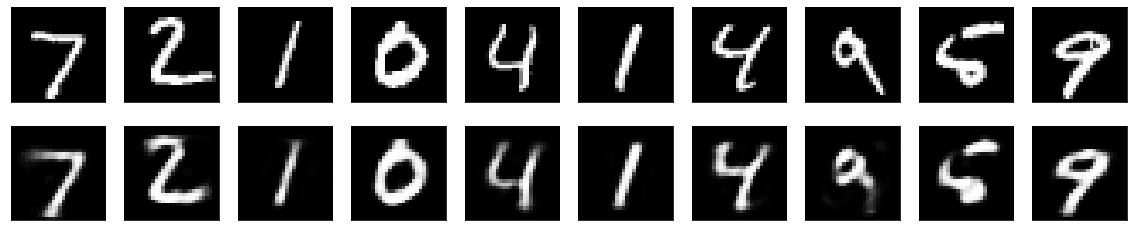

In [3]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)
# use Matplotlib
import matplotlib.pyplot as plt
n = 10 # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i].reshape(28, 28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i].reshape(28, 28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()


**3.2.1 Exercice**

La fonction de model.fit() lance l’entraînement du modèle avec le nombre de phases (epoch)
d’entraînement et la taille du batch
Modifiez ces paramètres avec epochs=50, et batch_size=256, et comparez les résultats d’affichage.


**3.3 Un auto-encodeur profond**

Nous n'avons pas à nous limiter à une seule couche comme encodeur ou décodeur, nous pourrions plutôt utiliser une pile de couches, telles que:


In [16]:
from keras.layers import Input, Dense
from keras.models import Model
# this is the size of our encoded representations
encoding_dim = 32
# 32 floats -> compression of factor 24.5, assuming the input is 784 floats
# this is our input placeholder
input_img = Input(shape=(784,))
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)
decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)
autoencoder = Model(input_img, decoded)
encoder = Model(input_img, encoded)
encoder.summary()





Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_39 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_40 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_41 (Dense)             (None, 32)                2080      
Total params: 110,816
Trainable params: 110,816
Non-trainable params: 0
_________________________________________________________________


In [15]:

# separate Decoder model
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim, ))
# retrieve the layers of the autoencoder model
decoder_layer1 = autoencoder.layers[-3]
decoder_layer2 = autoencoder.layers[-2]
decoder_layer3 = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer3(decoder_layer2(decoder_layer1(encoded_input))))
decoder.summary()



Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 32)                0         
_________________________________________________________________
dense_36 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_37 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_38 (Dense)             (None, 784)               101136    
Total params: 111,568
Trainable params: 111,568
Non-trainable params: 0
_________________________________________________________________


In [17]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.fit(x_train, x_train,epochs=10,batch_size=64,shuffle=True,validation_data=(x_test, x_test))



Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 7s 123us/step - loss: 0.2646 - val_loss: 0.2134
Epoch 2/10
60000/60000 [==============================] - 7s 119us/step - loss: 0.1948 - val_loss: 0.1769
Epoch 3/10
60000/60000 [==============================] - 7s 119us/step - loss: 0.1701 - val_loss: 0.1610
Epoch 4/10
60000/60000 [==============================] - 7s 119us/step - loss: 0.1558 - val_loss: 0.1477
Epoch 5/10
60000/60000 [==============================] - 7s 122us/step - loss: 0.1454 - val_loss: 0.1397
Epoch 6/10
60000/60000 [==============================] - 7s 122us/step - loss: 0.1383 - val_loss: 0.1330
Epoch 7/10
60000/60000 [==============================] - 7s 122us/step - loss: 0.1331 - val_loss: 0.1298
Epoch 8/10
60000/60000 [==============================] - 7s 119us/step - loss: 0.1294 - val_loss: 0.1283
Epoch 9/10
60000/60000 [==============================] - 7s 122us/step - loss: 0.1260 - val_loss: 0.1

**3.3.1 Code complet de l’auto-encodeur profond**


Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 32)                0         
_________________________________________________________________
dense_48 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_49 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_50 (Dense)             (None, 784)               101136    
Total params: 111,568
Trainable params: 111,568
Non-trainable params: 0
_________________________________________________________________
Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 784)               0         
__________________________________

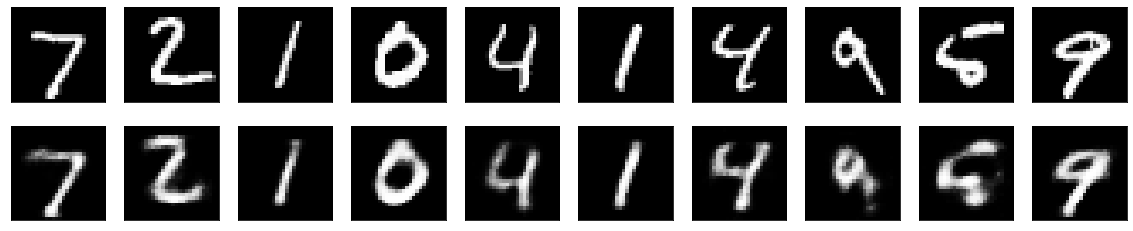

In [18]:
from keras.layers import Input, Dense
from keras.models import Model
# this is the size of our encoded representations
encoding_dim = 32
# 32 floats -> compression of factor 24.5, assuming the input is 784 floats
# this is our input placeholder
input_img = Input(shape=(784,))
# encoder part
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)
# decoder part
decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)
# separate models for autoencoder, encoder and decoder
autoencoder = Model(input_img, decoded)
encoder = Model(input_img, encoded)
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# create the decoder model
# retrieve the last layer of the autoencoder model
decoder_layer1 = autoencoder.layers[-3]
decoder_layer2 = autoencoder.layers[-2]
decoder_layer3 = autoencoder.layers[-1]
decoder = Model(encoded_input,
decoder_layer3(decoder_layer2(decoder_layer1(encoded_input))))
decoder.summary()
decoder.save('autoenc_deep_decoder.h5')
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.summary()
autoencoder.save('autoenc_deep.h5')
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
autoencoder.fit(x_train, x_train,
epochs=10,
batch_size=64,
shuffle=True,
validation_data=(x_test, x_test))
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)
import matplotlib.pyplot as plt
n = 10 # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i].reshape(28, 28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i].reshape(28, 28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()



**Figure 3.5** Images avant encodage et après encodage-décodage

**3.4 Auto-encodeur convolutif**

Puisque nos entrées sont des images, il est logique d'utiliser des réseaux de neurones convolutionnels
(**convnets**) comme **encodeurs** et **décodeurs**. Dans les paramètres pratiques, les auto-encodeurs appliqués
aux images sont toujours des encodeurs automatiques convolutifs - ils fonctionnent tout simplement beaucoup
mieux.
Notre **encodeur** consiste en une pile de couches **Conv2D** et **MaxPooling2D** (le regroupement maximal étant
utilisé pour le sous-échantillonnage spatial), tandis que le décodeur consiste en une pile de couches **Conv2D**
et **UpSampling2D**.


In [16]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
input_img = Input(shape=(28, 28, 1))
# adapt this if using `channels_first` image data format
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
# at this point the representation is (4, 4, 8) i.e. 128-dimensional
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.summary()



Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 4, 4, 8)           0   

In [3]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32')/255.
x_test = x_test.astype('float32')/255.
x_train = np.reshape(x_train,(len(x_train), 28, 28, 1)) 
# adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

autoencoder.fit(x_train, x_train,epochs=50,batch_size=128,shuffle=True,validation_data=(x_test, x_test))



Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 13s 212us/step - loss: 0.2151 - val_loss: 0.1647
Epoch 2/50
60000/60000 [==============================] - 6s 95us/step - loss: 0.1518 - val_loss: 0.1413
Epoch 3/50
60000/60000 [==============================] - 6s 98us/step - loss: 0.1371 - val_loss: 0.1287
Epoch 4/50
60000/60000 [==============================] - 6s 98us/step - loss: 0.1302 - val_loss: 0.1273
Epoch 5/50
60000/60000 [==============================] - 6s 98us/step - loss: 0.1255 - val_loss: 0.1210
Epoch 6/50
60000/60000 [==============================] - 6s 100us/step - loss: 0.1221 - val_loss: 0.1214
Epoch 7/50
60000/60000 [==============================] - 6s 99us/step - loss: 0.1194 - val_loss: 0.1169
Epoch 8/50
60000/60000 [==============================] - 6s 100us/step - loss: 0.1171 - val_loss: 0.1144
Epoch 9/50
60000/60000 [==============================] - 6s 99us/step - loss: 0.1152 - val_loss: 0.1115
E

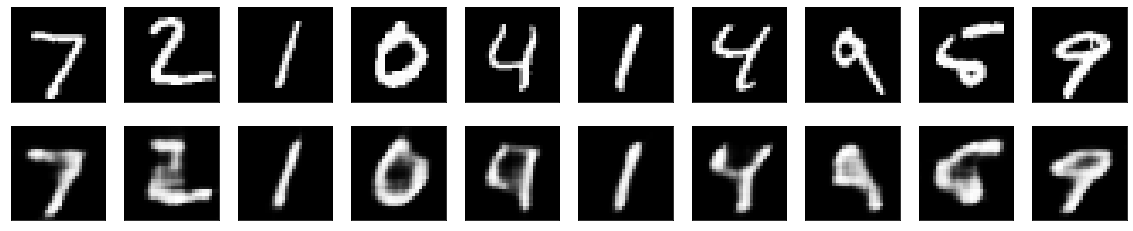

In [14]:
autoencoder.save('conv_autoencoder')

import matplotlib.pyplot as plt
decoded_imgs = autoencoder.predict(x_test)
n=10
plt.figure(figsize=(20,4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i+1)
  plt.imshow(x_test[i].reshape(28, 28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  # display reconstruction
  ax = plt.subplot(2, n, i +1+ n)
  plt.imshow(decoded_imgs[i].reshape(28, 28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()


**Figure 3.6** Images avant encodage et après encodage-décodage (modèle convolutive)



Nous pouvons également jeter un œil aux représentations codées à 128 ou 64 dimensions. Ces représentations
sont 8x4x4, nous les remodelons donc en 4x32 afin de pouvoir les afficher sous forme d'images en niveaux de
gris.


NameError: ignored

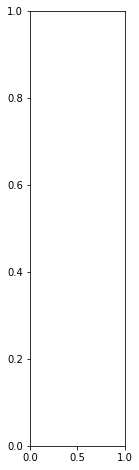

In [15]:
n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
  ax = plt.subplot(1, n, i+1)
  plt.imshow(encoded_imgs[i].reshape(4, 4 * 8).T)
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()


**3.4.1 Code complet de l’auto-encodeur convolutif**


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 28, 28, 8)         80        
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 14, 14, 4)         292       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 7, 7, 4)           0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 7, 7, 4)           148       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 4, 4, 4)           0   

NameError: ignored

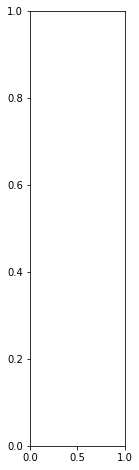

In [17]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
input_img = Input(shape=(28, 28, 1))
# adapt this if using `channels_first` image data format
x = Conv2D(8, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(4, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(4, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
# at this point the representation is (4, 4, 8) i.e. 128-dimensional
x = Conv2D(4, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(4, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.summary()
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
# adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))
# adapt this if using `channels_first` image data format
autoencoder.fit(x_train, x_train,epochs=10,batch_size=64,shuffle=True,validation_data=(x_test, x_test),verbose=1)
autoencoder.save('autoenc_conv.h5')
# encode and decode some digits







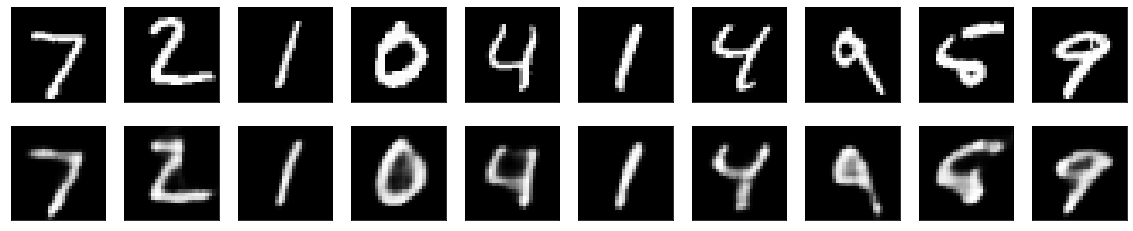

In [18]:
import matplotlib.pyplot as plt
n = 10 # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i].reshape(28, 28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i].reshape(28, 28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()


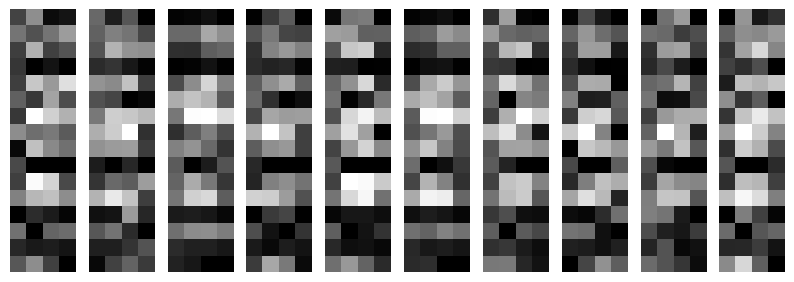

In [19]:
encoder = Model(input_img, encoded)
encoded_imgs = encoder.predict(x_test)
plt.figure(figsize=(10, 4), dpi=100)
for i in range(n):
  ax = plt.subplot(1, n, i + 1)
  plt.imshow(encoded_imgs[i].reshape(4,4*4).T) # 8 => 4
  plt.gray()
  ax.set_axis_off()
plt.show()



**3.5 Application au débruitage d'image**

Mettons notre encodeur automatique convolutionnel au travail sur un problème de débruitage d'image. C'est
simple: nous allons former l'auto-encodeur pour mapper des images de chiffres bruités à des images de chiffres
propres.

Voici comment nous allons générer des chiffres bruités : nous appliquons simplement une matrice de bruit
gaussienne et progetons les images sur les valeurs entre 0 et 1.


In [22]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1)) # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1)) # adapt this if using `channels_first` image data format
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0,
size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0,
size=x_test.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)


Voici à quoi ressemblent les chiffres bruités:


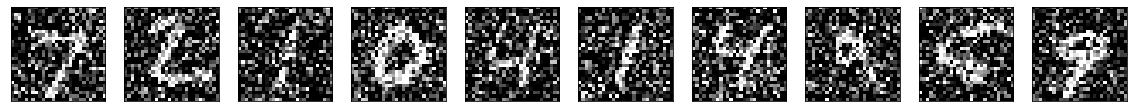

In [23]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
  ax = plt.subplot(1, n, i+1)
  plt.imshow(x_test_noisy[i].reshape(28, 28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()


Si vous plissez les yeux, vous pouvez toujours les reconnaître, mais à peine. Notre encodeur automatique peut-
il apprendre à récupérer les chiffres d'origine? Découvrons-le.
Par rapport au précédent auto-encodeur convolutif, afin d'améliorer la qualité de la reconstruction, nous
utiliserons un modèle légèrement différent avec plus de filtres par couche:


**Attention**

L’entraînement de ce modèle avec les **32 filtres** *n’est pas possible* sur la carte **Jetson Nano** dont la RAM
partagée (CPU et GPU) est limité à **4Go**.
Dans le code complet nous proposons seulement 8 filtres pour les couches **Conv2D**.


In [ ]:
input_img = Input(shape=(28, 28, 1))
image data format
# adapt this if using `channels_first`
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
# at this point the representation is (7, 7, 32)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
# Let's train it for 100 epochs:
autoencoder.fit(x_train_noisy, x_train,epochs=100,batch_size=128,shuffle=True,validation_data=(x_test_noisy, x_test),
callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0,write_graph=False)])


Voyons maintenant les résultats. En haut, les chiffres bruités qui alimentent le réseau, et en bas, les chiffres
reconstruits par le réseau.


**3.5.1 Code complet de l’auto-encodeur convolutif pour le débruitage**


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 16)        4624      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 7, 7, 16)          2320      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 4, 4, 16)          0   

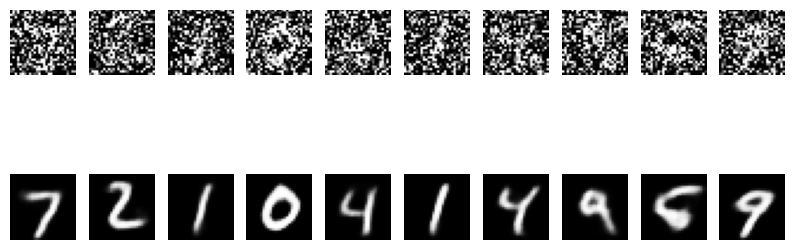

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [2]:
from tensorflow import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
import sys
input_img = Input(shape=(28, 28, 1)) # adapt this if using `channels_first` image data format
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)  # 8->32
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)  # 4->16
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)  # 4->16
encoded = MaxPooling2D((2, 2), padding='same')(x)
# at this point the representation is (4, 4, 8) i.e. 128-dimensional
x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded) # 4->16
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x) # 4->16
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu')(x) # 8->32
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.summary()
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1)) # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1)) # adapt this if using `channels_first` image data format
noise_factor = 0.95 # set as argument
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0,
size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0,
size=x_test.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
autoencoder.fit(x_train_noisy, x_train,epochs=10,batch_size=64,shuffle=True,validation_data=(x_test, x_test),verbose=1)
autoencoder.save('autoenc_conv_denoise.h5')
# Recreate the exact same model purely from the file
new_model = keras.models.load_model('autoenc_conv_denoise.h5')
# encode and decode some digits
# note that we take them from the *test* set
#decoded_imgs = autoencoder.predict(x_test)
decoded_imgs = new_model.predict(x_test)
import matplotlib.pyplot as plt
n = 10
plt.figure(figsize=(10, 4), dpi=100)
for i in range(n):
  # display noisy
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test_noisy[i].reshape(28, 28))
  plt.gray()
  ax.set_axis_off()
  # display reconstruction
  ax = plt.subplot(2, n, i + n + 1)
  plt.imshow(decoded_imgs[i].reshape(28, 28))
  plt.gray()
  ax.set_axis_off()
plt.show()

from google.colab import files
files.download("autoenc_conv_denoise.h5")



